# STEP 1: Load Required Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix

nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# STEP 2: Load Dataset


sentiment
negative    695
positive    122
neutral      33
Name: count, dtype: int64


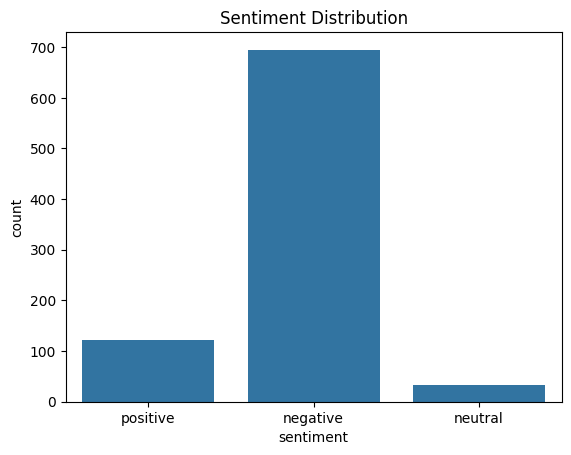

In [6]:
df = pd.read_csv('/content/drive/MyDrive/archive (1)/reviews_data.csv')
df.dropna(subset=['Review'], inplace=True)  # Drop rows with missing reviews

# Create sentiment column based on Rating
def rating_to_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['Rating'].apply(rating_to_sentiment)
print(df['sentiment'].value_counts())

# Optional visualization
sns.countplot(data=df, x='sentiment')
plt.title("Sentiment Distribution")
plt.show()


In [7]:
df.head()

,name,location,Date,Rating,Review,Image_Links,sentiment
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,['No Images'],positive
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,['No Images'],positive
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,['https://media.consumeraffairs.com/files/cach...,positive
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,['No Images'],positive
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,['https://media.consumeraffairs.com/files/cach...,positive


In [8]:
df.tail()


,name,location,Date,Rating,Review,Image_Links,sentiment
845,Becky,"Agoura Hills, CA","Reviewed July 13, 2006",NaN,I ordered two venti frappacino's without whipp...,['No Images'],negative
846,Bob,"Goodrich, MI","Reviewed Jan. 3, 2005",NaN,No Review Text,['No Images'],negative
847,Erik,"Valley Village, CA","Reviewed Nov. 5, 2004",NaN,"DEMANDED TIPS FROM ME, THEN MADE ME WAIT UNTIL...",['No Images'],negative
848,Andrew,"Fallbrook, CA","Reviewed Oct. 20, 2004",NaN,No Review Text,['No Images'],negative
849,Christian,"Ramsey, NJ","Reviewed July 19, 2000",NaN,No Review Text,['No Images'],negative


In [9]:

df.describe()

,Rating
count,705.000000
mean,1.870922
std,1.397672
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,5.000000


In [10]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         850 non-null    object 
 1   location     850 non-null    object 
 2   Date         850 non-null    object 
 3   Rating       705 non-null    float64
 4   Review       850 non-null    object 
 5   Image_Links  850 non-null    object 
 6   sentiment    850 non-null    object 
dtypes: float64(1), object(6)
memory usage: 46.6+ KB


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
df.isna().sum()

,0
name,0
location,0
Date,0
Rating,145
Review,0
Image_Links,0
sentiment,0


In [12]:
for i in range(df.shape[1]):
  print(df.iloc[:,i].unique())

['Helen' 'Courtney' 'Daynelle' 'Taylor' 'Tenessa' 'Alyssa' 'ken' 'Nikki'
 'Alex' 'Sunny' 'Breggetta' 'Shannon' 'Lucy' 'RAYMOND' 'Thomas' 'Felicia'
 'Sean' 'Charles' 'Miya' 'Ann' 'Vicki' 'VD' 'Jennifer' 'Mark' 'Chris'
 'Elizabeth' 'Kemmis' 'Eva' 'Tiffany' 'Kseniia' 'Nilly' 'Latasha'
 'William' 'James' 'vincent' 'J' 'Brenda' 'ANDRU' 'Marlene' 'Paul'
 'Trenton' 'Ryan' 'Ian' 'john' 'B' 'Diana' 'Ariane' 'Kimberly' 'Susanne'
 'Gina' 'Kenneth' 'Marmar' 'Nildee' 'Lloyd' 'Lauren' 'Aryelle' 'Roy'
 'Wendy' 'Bertha' 'Christopher' 'Sharon' 'Lukas' 'David' 'Pamela'
 'Brooklyn' 'IAm' 'Julie' 'Aaron' 'Billy' 'Ivan' 'Samantha' 'Jacqueline'
 'RC' 'EADream' 'Elle' 'Tasha' 'Phil' 'Angeline' 'Edwin' 'Robin' 'Fazlin'
 'Denise' 'Patrick' 'John' 'Abhinav' 'Uday' 'Erica' 'Julia' 'Savaa' 'Izzy'
 'Spiros' 'Ayako' 'Karen' 'Donald' 'Steven' 'D.' 'Ronald' 'Mario' 'Johnna'
 'Mary Beth' 'Val' 'Miera' 'kateryna' 'JP' 'Giu' 'terri' 'Kimmy' 'Tameka'
 'Shanda' 'Jamika' 'M' 'Linda' 'Jeff' 'Cathy' 'Laura' 'Bobbie' 'Anthony

In [13]:
df.columns

Index(['name', 'location', 'Date', 'Rating', 'Review', 'Image_Links',
       'sentiment'],
      dtype='object')

In [14]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

nltk.download('stopwords')  # You already have this but safe to include

stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')

def clean_text(text):
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    filtered = [word for word in tokens if word not in stop_words]
    return " ".join(filtered)

df['cleaned_text'] = df['Review'].astype(str).apply(clean_text)
df[['Review', 'cleaned_text', 'sentiment']].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Review,cleaned_text,sentiment
0,Amber and LaDonna at the Starbucks on Southwes...,amber ladonna starbucks southwest parkway alwa...,positive
1,** at the Starbucks by the fire station on 436...,starbucks fire station 436 altamonte springs f...,positive
2,I just wanted to go out of my way to recognize...,wanted go way recognize starbucks employee bil...,positive
3,Me and my friend were at Starbucks and my card...,friend starbucks card work thankful worker pai...,positive
4,I’m on this kick of drinking 5 cups of warm wa...,kick drinking 5 cups warm water work instacart...,positive


# STEP 4: Tokenize & Pad Sequences

In [15]:


tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post')

# Encode Sentiment Labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['sentiment'])

X = padded_sequences
y = df['label']


# STEP 5: Train/Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# STEP 6: Build the Model (LSTM)

In [17]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=64, input_length=100))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# STEP 7: Train the Model

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.7229 - loss: 0.8645 - val_accuracy: 0.7588 - val_loss: 0.6872
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8108 - loss: 0.6287 - val_accuracy: 0.7588 - val_loss: 0.7017
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8333 - loss: 0.5802 - val_accuracy: 0.7588 - val_loss: 0.6751
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8396 - loss: 0.5570 - val_accuracy: 0.7588 - val_loss: 0.6724
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8292 - loss: 0.5741 - val_accuracy: 0.7588 - val_loss: 0.6752
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8292 - loss: 0.5660 - val_accuracy: 0.7588 - val_loss: 0.6870
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8412 - loss: 0.5437 - val_accuracy: 0.7588 - val_loss: 0.6630
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8422 - loss: 0.5344 - val_accuracy: 0.7588 - v

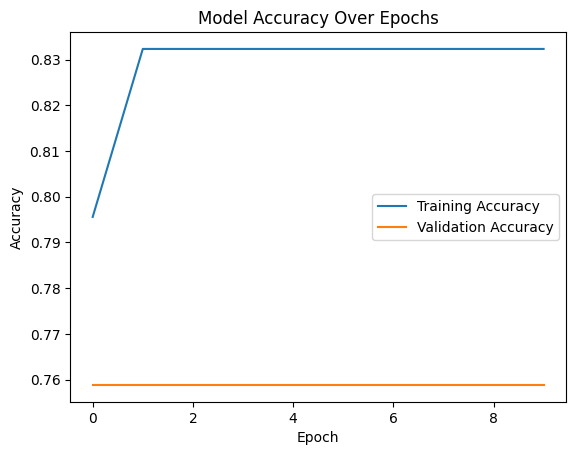

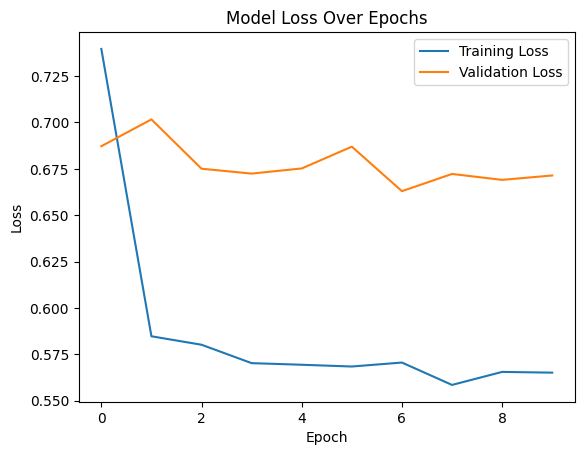

In [18]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


# STEP 8: Evaluate the Model

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7472 - loss: 0.6890 
Test Accuracy: 75.88%
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
              precision    recall  f1-score   support

    negative       0.76      1.00      0.86       129
     neutral       0.00      0.00      0.00         5
    positive       0.00      0.00      0.00        36

    accuracy                           0.76       170
   macro avg       0.25      0.33      0.29       170
weighted avg       0.58      0.76      0.65       170



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


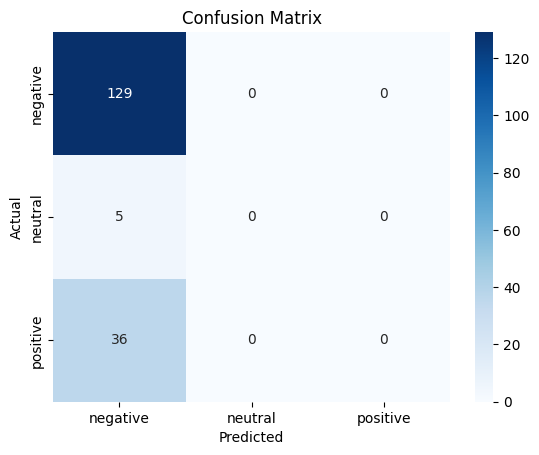

In [31]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_) # Assuming le is your LabelEncoder
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

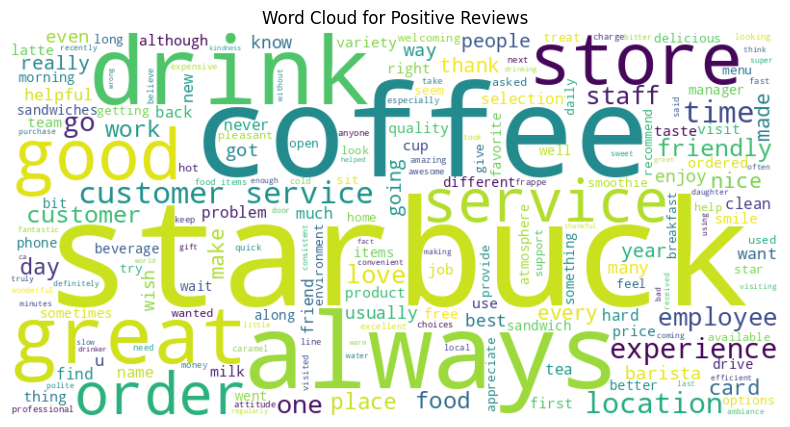

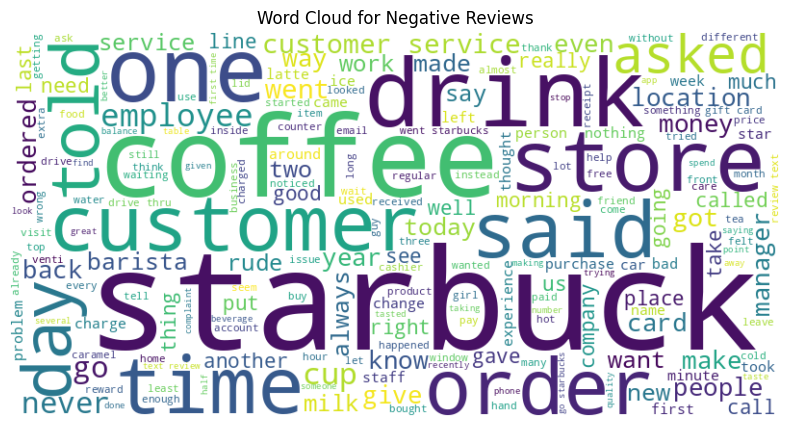

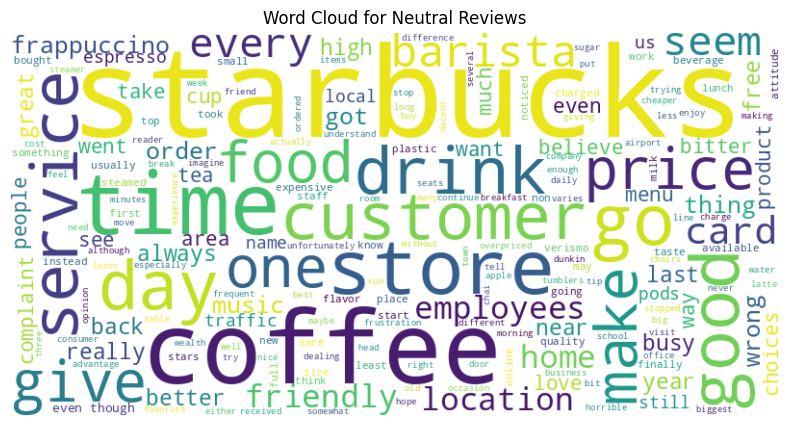

In [20]:
from wordcloud import WordCloud

for sentiment in df['sentiment'].unique():
    text = " ".join(df[df['sentiment'] == sentiment]['cleaned_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for {sentiment.capitalize()} Reviews")
    plt.axis('off')
    plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


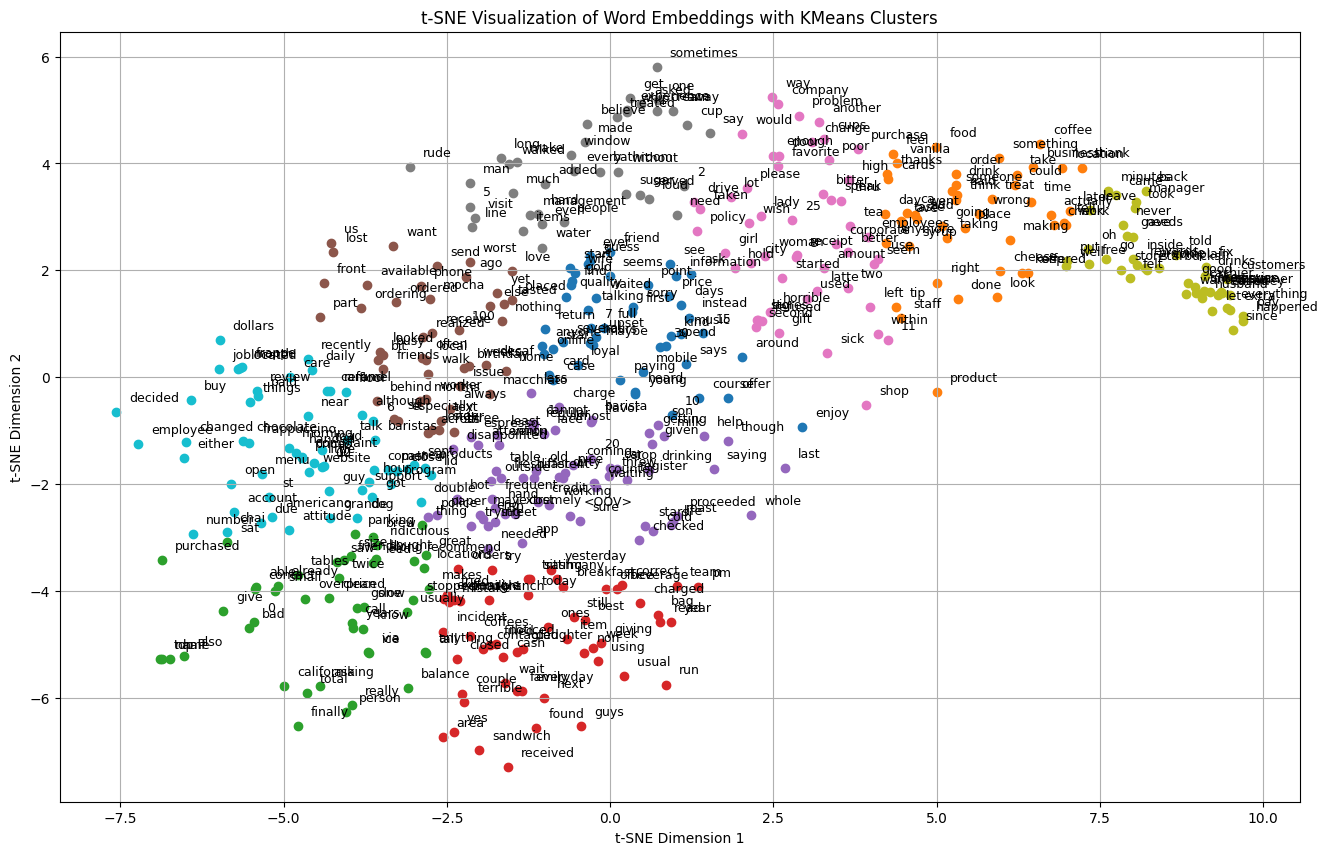

In [21]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Get the embedding weights from the Embedding layer
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]

# Get word index and reverse it
word_index = tokenizer.word_index
index_word = {v: k for k, v in word_index.items()}

# Select top N words to visualize (excluding 0 which is padding)
top_n = 500
words = [index_word[i] for i in range(1, top_n+1) if i in index_word]
vectors = weights[1:top_n+1]  # Skip the padding token at index 0

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=40, n_iter=300)
reduced_vecs = tsne.fit_transform(vectors)

# Apply KMeans clustering
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(reduced_vecs)

# Plot the clusters
plt.figure(figsize=(16, 10))
for i, word in enumerate(words):
    plt.scatter(reduced_vecs[i, 0], reduced_vecs[i, 1], c=f"C{labels[i]}")
    plt.annotate(word, (reduced_vecs[i, 0]+0.2, reduced_vecs[i, 1]+0.2), fontsize=9)
plt.title("t-SNE Visualization of Word Embeddings with KMeans Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()


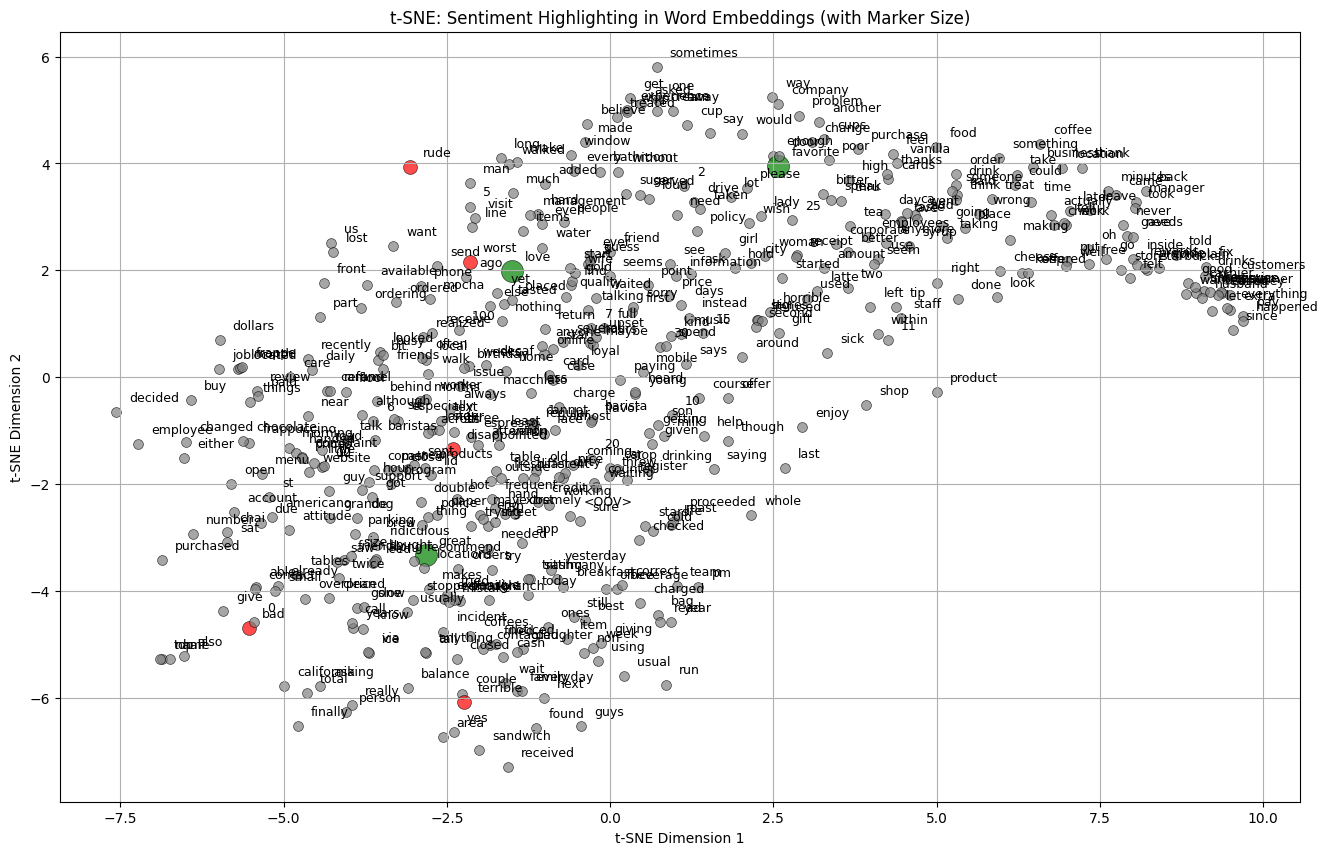

In [32]:
positive_words = {'love', 'great', 'favorite', 'happy', 'delicious'}
negative_words = {'terrible', 'rude', 'worst', 'bad', 'disappointed'}

colors = []
sizes = []

for word in words:
    if word in positive_words:
        colors.append('green')
        sizes.append(250)   # Bigger circle for positive
    elif word in negative_words:
        colors.append('red')
        sizes.append(100)    # Slightly smaller for negative
    else:
        colors.append('gray')
        sizes.append(50)    # Small for neutral/other

plt.figure(figsize=(16, 10))
for i, word in enumerate(words):
    plt.scatter(reduced_vecs[i, 0], reduced_vecs[i, 1],
                color=colors[i], s=sizes[i], alpha=0.7, edgecolors='k', linewidths=0.5)
    plt.annotate(word, (reduced_vecs[i, 0]+0.2, reduced_vecs[i, 1]+0.2), fontsize=9)

plt.title("t-SNE: Sentiment Highlighting in Word Embeddings (with Marker Size)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()


### ✅ Final Accuracy & Loss Summary

In [33]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

Final Training Accuracy: 0.8324
Final Validation Accuracy: 0.7588
Final Training Loss: 0.5651
Final Validation Loss: 0.6714
